In [131]:
import os
import pandas as pd
import numpy as np
import random


import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, auc,roc_curve, precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier,  AdaBoostClassifier


from matplotlib import pyplot as plt
import seaborn as sns


pd.options.mode.chained_assignment = None  
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 50) 

### Functions

In [132]:
# 1. Fun
def encode_and_bind(original_dataframe, feature_to_encode):

    """
This fucnction makes One-hot-encoding
    Input: 
    - datatable with deal_kul_id and need features
    - feature for One-hot-encoding
    Output: 
    - datatable with One-hot-encoding features
    
    """
    #1. Make dummies and OHE     
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1).drop(feature_to_encode, axis=1)
    
    return(res)

In [133]:
# 2. Fun
def feature_important(model):
    
    """
This fucnction shows feature imortants
    Input: 
    - model  
    
    Output: 
    - table with score of feature importants
    - plot with score of feature importants
    
    """    

    feature_important = model.get_booster().get_score(importance_type='weight')
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    global data
    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.plot(kind='barh');

    return data  

In [134]:
# 3. Fun
def GS_table(learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma,i_index  ):
    """
This fucnction makes GS table
    Input: 
    - parameres for greed search : learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma,i_index
    
    Output: 
    - GS table
    
    """ 
    
    # 1. Data preporation
    learning_rate = pd.DataFrame(learning_rate, columns = ['learning_rate'])
    max_depth = pd.DataFrame(max_depth, columns = ['max_depth'])
    n_estimators = pd.DataFrame(n_estimators, columns = ['n_estimators'])
    subsample = pd.DataFrame(subsample, columns = ['subsample'])
    colsample_bytree = pd.DataFrame(colsample_bytree, columns = ['colsample_bytree'])
    gamma= pd.DataFrame(gamma, columns = ['gamma'])
    i_index = pd.DataFrame(i_index, columns = ['i_index'])
    
    
    # 2. Technical moments
    learning_rate['key'] = 0
    n_estimators['key'] = 0
    subsample['key'] = 0
    max_depth['key'] = 0
    colsample_bytree['key'] = 0
    gamma['key'] = 0
    i_index['key'] = 0
    
    
    # 3. Merge data     
    global grid_tab
    grid_tab = pd.merge(learning_rate, n_estimators, how = 'outer').\
    merge(subsample, how = 'outer' ).\
    merge(max_depth, how = 'outer' ).\
    merge(colsample_bytree, how = 'outer' ).\
    merge(gamma, how = 'outer' ).\
    merge(i_index, how = 'outer' ).\
    drop('key', axis= 1)
    
    # 4. Assign mae  
    grid_tab['auc1'] = 0.0
    grid_tab['auc2'] = 0.0
    grid_tab['auc3'] = 0.0
    grid_tab['auc_avg'] = 0.0

    # 5 Show shape grd_data
    print(grid_tab.shape)

In [135]:
# 4. Fun
def feature_description(feature, data, barplot = None):
    print('Analyzed feature: ',feature)
    
    if (data[feature].dtypes == 'int64') & (barplot == None):
        
        plt.figure(figsize=(10,5)) 
        plt.hist(data[feature]);

        # look at destribution depends on target
        sns.catplot(x=feature, y="bad_client_target",
                        kind="box", orient="h", data=data);
        
    else:
        # look at destribution
        data[feature].value_counts().plot(kind='bar');

        # look at destribution depends on target
        sns.catplot(x=feature, y="bad_client_target",  kind="bar", data=data);

### Part 1. Data preprocessing


#### 1.1 Download data

In [136]:
# 1. Set path and download data 

path = os.path.dirname(os.path.abspath('__file__'))
data = pd.read_csv(path.replace('project', '')+'data\\clients.csv', sep=',' )

print('data shape:',data.shape)

data shape: (1723, 14)


#### 1.2 Main description

In [137]:
# 1. Main description
data.describe()

,month,credit_amount,credit_term,age,having_children_flg,region,income,phone_operator,is_client,bad_client_target
count,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000
mean,6.708067,29264.654672,11.546721,35.911782,0.428323,1.681370,32652.350551,1.125363,0.604759,0.113755
std,3.538420,27926.778301,6.548354,13.120203,0.494979,0.704256,20913.193158,1.015822,0.489044,0.317606
min,1.000000,5000.000000,3.000000,18.000000,0.000000,0.000000,1000.000000,0.000000,0.000000,0.000000
25%,3.000000,13000.000000,6.000000,26.000000,0.000000,2.000000,21000.000000,0.000000,0.000000,0.000000
50%,7.000000,21500.000000,12.000000,32.000000,0.000000,2.000000,27000.000000,1.000000,1.000000,0.000000
75%,10.000000,34000.000000,12.000000,44.000000,1.000000,2.000000,38000.000000,2.000000,1.000000,0.000000
max,12.000000,301000.000000,36.000000,90.000000,1.000000,2.000000,401000.000000,4.000000,1.000000,1.000000


In [138]:
# 2. Look at NA
data.isna().sum()

month                  0
credit_amount          0
credit_term            0
age                    0
sex                    0
education              0
product_type           0
having_children_flg    0
region                 0
income                 0
family_status          0
phone_operator         0
is_client              0
bad_client_target      0
dtype: int64

In [139]:
# 3. Look at main info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1723 entries, 0 to 1722
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   month                1723 non-null   int64 
 1   credit_amount        1723 non-null   int64 
 2   credit_term          1723 non-null   int64 
 3   age                  1723 non-null   int64 
 4   sex                  1723 non-null   object
 5   education            1723 non-null   object
 6   product_type         1723 non-null   object
 7   having_children_flg  1723 non-null   int64 
 8   region               1723 non-null   int64 
 9   income               1723 non-null   int64 
 10  family_status        1723 non-null   object
 11  phone_operator       1723 non-null   int64 
 12  is_client            1723 non-null   int64 
 13  bad_client_target    1723 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 188.6+ KB


#### Conclusion:
1. No problem with na
2. We can change type for sex and family_status

#### 1.3 Look at dependent variable

0    1527
1     196
Name: bad_client_target, dtype: int64

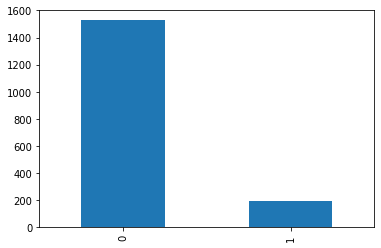

In [140]:
data['bad_client_target'].value_counts().plot(kind='bar');
data.bad_client_target.value_counts()

#### Conclusion:
1. There is an imbalance problem

#### 1.4 Look at independent variable

Analyzed feature:  month


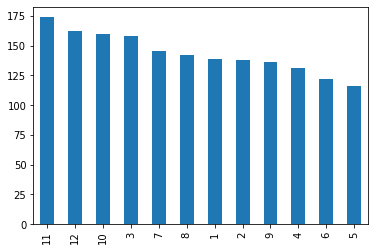

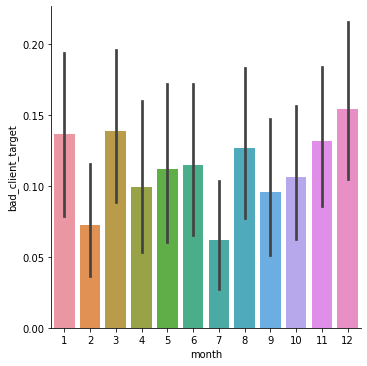

In [141]:
# feature

feature = data.columns[0]
feature_description(feature, data,barplot =True)

#### Conclusion:
1. Majority bad clients in december
2. Minority in July

Analyzed feature:  credit_amount


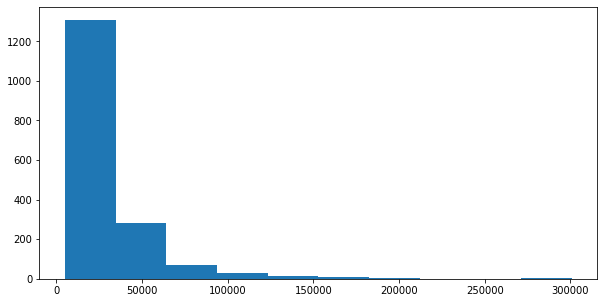

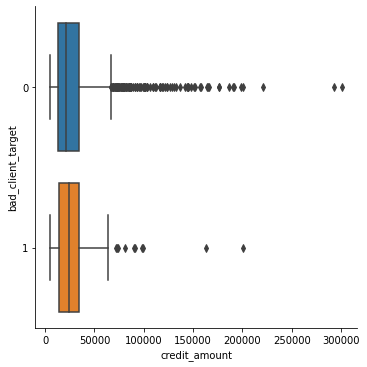

In [142]:
# feature

feature = data.columns[1]
feature_description(feature, data)

In [143]:
# change data
data['big_credit_amount'] = np.where(data[feature] < np.quantile(data[feature],0.95), 0, 1)

Analyzed feature:  credit_term


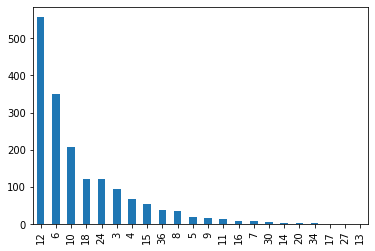

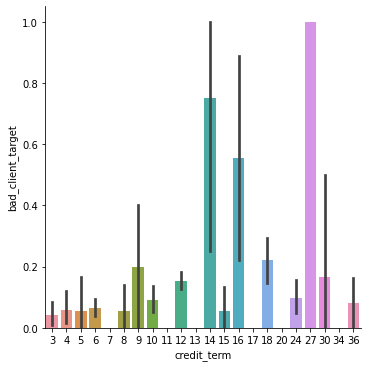

In [144]:
# feature

feature = data.columns[2]
feature_description(feature, data,barplot =True)

#### Conclusion:
1. Almost 100% bad clents with credit term = 27 but the q of them is not enoght
2. It is good to create a feature wich show that credit term is high
3. The share of bad clients higher for long term

Analyzed feature:  age


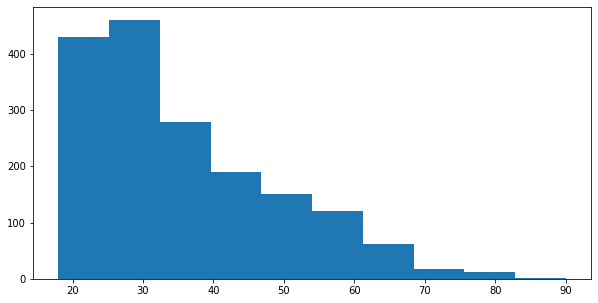

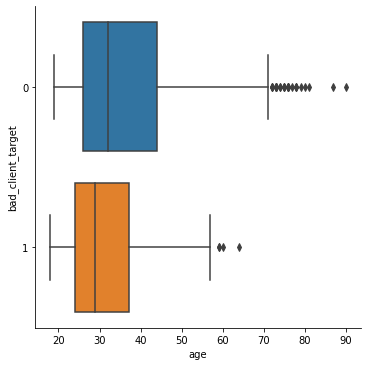

In [145]:
# feature

feature = data.columns[3]
feature_description(feature, data)

#### Conclusion:
Younger people are more likely bad clients

Analyzed feature:  sex


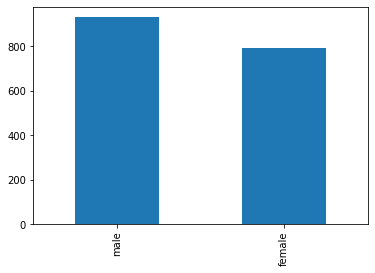

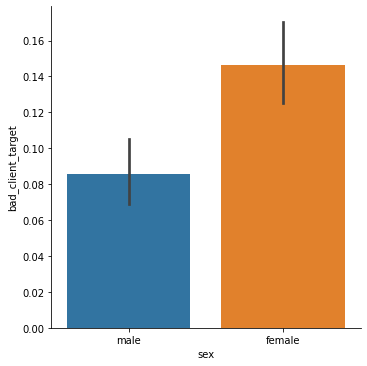

In [146]:
# feature

feature = data.columns[4]
feature_description(feature, data)

In [147]:
# change data
data['is_male'] = np.where(data[feature].isin(['male']), 1,0)


#### Conclusion:
Female are more likely bad clients

Analyzed feature:  education


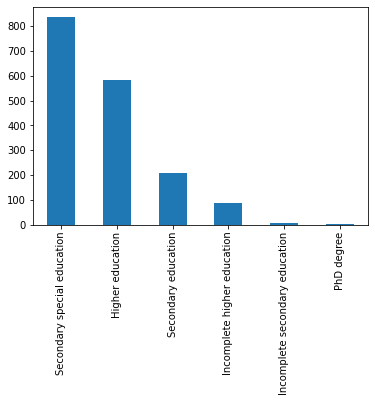

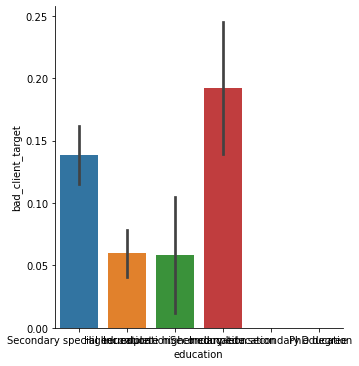

In [148]:
# feature

feature = data.columns[5]
feature_description(feature, data)

In [149]:
# change data
data[feature] = np.where(data[feature].isin(['PhD degree', 'Incomplete secondary education']), 'Other', data[feature])


#### Conclusion:
Bad education influences on type of clint in a negative way

Analyzed feature:  product_type


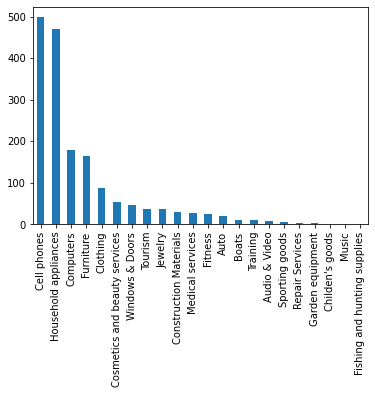

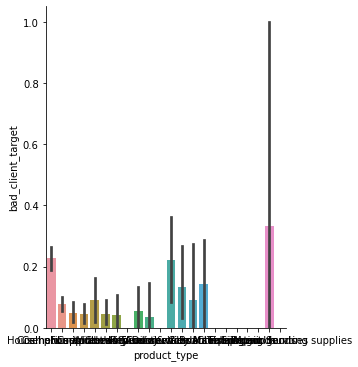

In [150]:
# feature

feature = data.columns[6]
feature_description(feature, data)

In [151]:
data[feature] = np.where(data[feature].isin(['Cell phones']), 'Cell phones', 
                         np.where(data[feature].isin(['Household appliances']), 'Household appliances',
                                  np.where(data[feature].isin(['Computers']), 'Computers',
                                           np.where(data[feature].isin(['Furniture']), 'Furniture',
                                                    np.where(data[feature].isin(['Clothing']), 'Clothing',
                                                             np.where(data[feature].isin(['Cosmetics and beauty services']), 'Cosmetics',
                                                                      'Other'))))))


Analyzed feature:  product_type


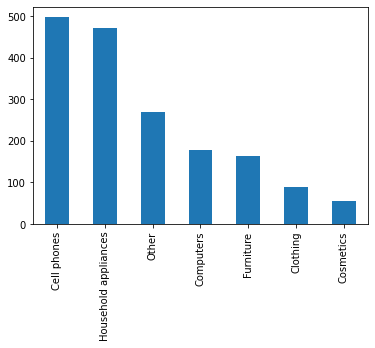

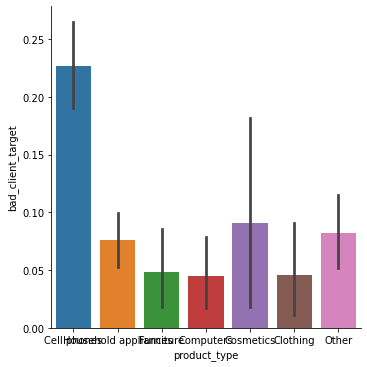

In [152]:
# feature

feature = data.columns[6]
feature_description(feature, data)

Analyzed feature:  having_children_flg


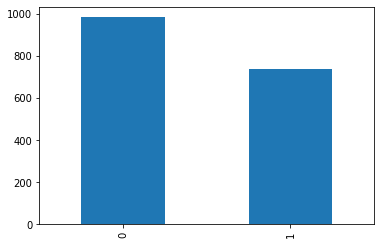

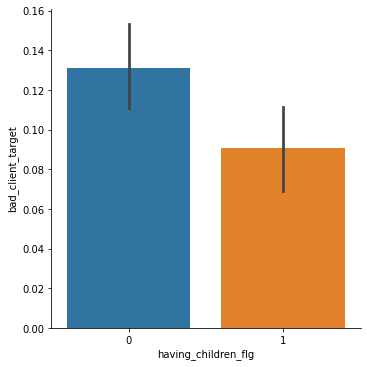

In [153]:
# feature

feature = data.columns[7]
feature_description(feature, data, barplot= True)

#### Conclusion:
If a clent has a children it is more likely that he/she is not a bad client

Analyzed feature:  region


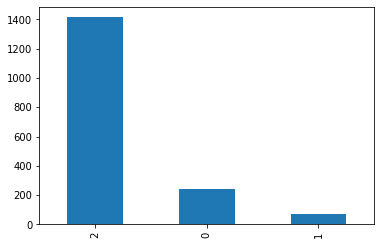

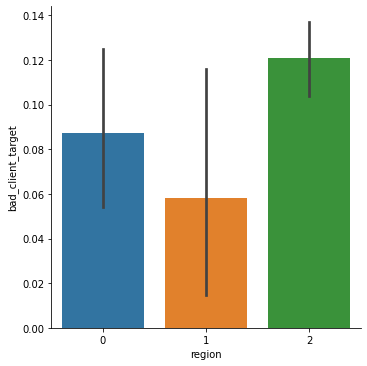

In [154]:
# feature

feature = data.columns[8]
feature_description(feature, data, barplot= True)

Analyzed feature:  income


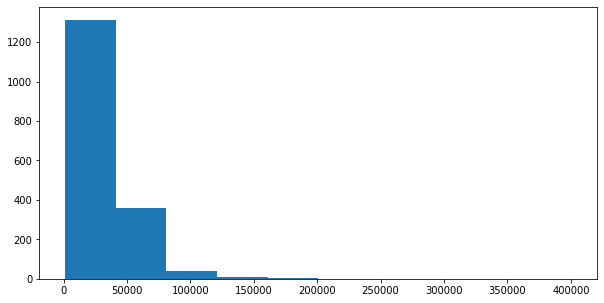

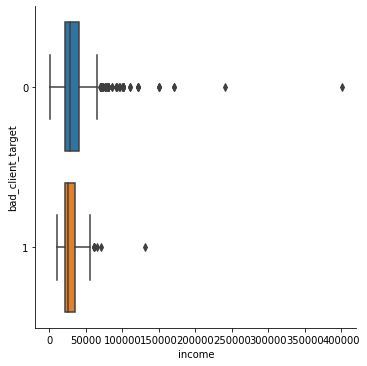

In [155]:
# feature

feature = data.columns[9]
feature_description(feature, data)

In [156]:
# change data
data['big_income'] = np.where(data[feature] < np.quantile(data[feature],0.95), 0, 1)

Analyzed feature:  family_status


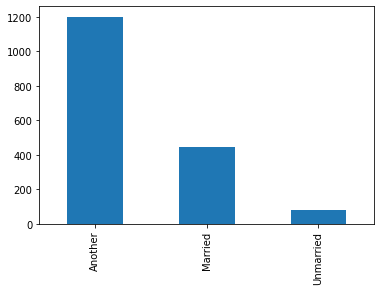

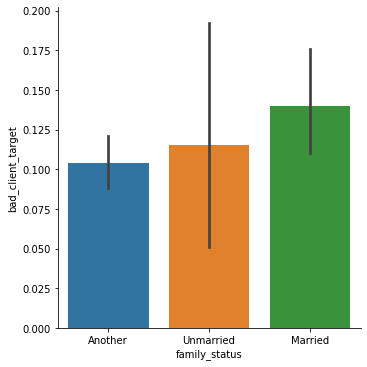

In [157]:
# feature

feature = data.columns[10]
feature_description(feature, data)

#### Conclusion:
 If a clent is married it is more likely that he/she is not a bad client

Analyzed feature:  phone_operator


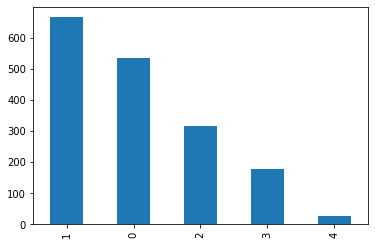

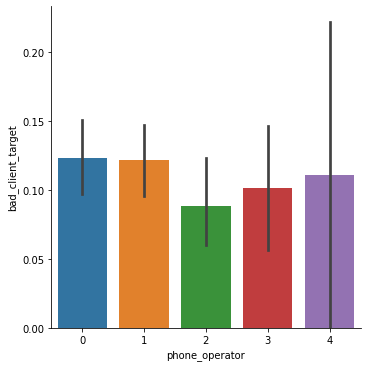

In [158]:
# feature

feature = data.columns[11]
feature_description(feature, data, barplot= True)

Analyzed feature:  is_client


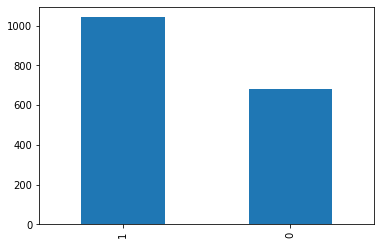

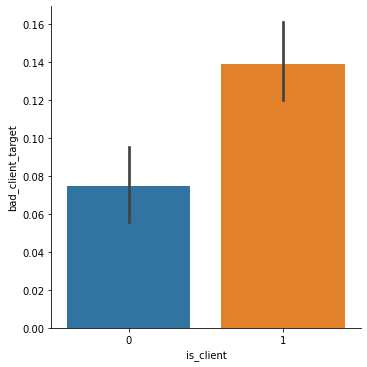

In [159]:
# feature

feature = data.columns[12]
feature_description(feature, data, barplot= True)

#### Conclusion:
If a clent is is_clents it is more likely that he/she is not a bad client

#### 1.5 One-hot-encoding

In [160]:
data = data.drop(['sex'], axis =1)

# OHE
data = encode_and_bind(data , 'education')
data = encode_and_bind(data , 'product_type')
data = encode_and_bind(data , 'family_status')

In [161]:
# Swap data
data = data[['bad_client_target', 'month', 'credit_amount', 'credit_term', 'age', 'having_children_flg',
       'region', 'income', 'phone_operator', 'is_client',
       'big_credit_amount', 'is_male', 'big_income', 
       'education_Higher education', 'education_Incomplete higher education',
       'education_Other', 'education_Secondary education',
       'education_Secondary special education', 'product_type_Cell phones',
       'product_type_Clothing', 'product_type_Computers',
       'product_type_Cosmetics', 'product_type_Furniture',
       'product_type_Household appliances', 'product_type_Other',
       'family_status_Another', 'family_status_Married',
       'family_status_Unmarried']]

data =  data.rename(columns={'bad_client_target':'y'})

#### 6 Train and test split

In [162]:
# split data on target and X
train = data


# split data on train data set
x_train, x_test = train_test_split(train, test_size=0.3, random_state=42);
print(x_train.shape)
print(x_test.shape)


(1206, 28)
(517, 28)


In [163]:
x_train = x_train[(x_train.big_credit_amount == 0) & (x_train.big_income == 0)]
x_train = x_train.drop(['big_credit_amount', 'big_income'], axis =1)
x_test = x_test.drop(['big_credit_amount', 'big_income'], axis =1)

In [164]:
y_train = x_train.y
y_test = x_test.y

x_train = x_train.iloc[:,1:]
x_test = x_test.iloc[:,1:]

### Part 2. Moddelling. Naive XGBoost

#### 2.1 Main table with result

In [165]:
res_tab = pd.DataFrame({'Method': ['naive', 'naive_plus_cleaning', 'advanced'],
             'auc':np.nan,
              'recall': np.nan} )

#### 2.2 train Naive model

In [166]:
%%time

# 0. set threshold 
threshold = 0.25

# 1. fitting 
xg_reg = xgb.XGBClassifier( n_jobs=5, random_state=777, objective='reg:logistic', use_label_encoder=False)
xg_reg.fit(x_train, y_train)


# 2. Prediction
prediction = xg_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
print('AUC: ', round(auc(fpr, tpr),2))


# 3. Prediction + threshold
prediction = np.where(prediction < threshold, 0, 1)

print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))

# 4. Save result
res_tab['auc'][0] = round(auc(fpr, tpr),2)
res_tab['recall'][0] = round(recall_score(y_pred = prediction, y_true = y_test),2)

AUC:  0.71
recall:  0.25
[[428  34]
 [ 41  14]]
Wall time: 123 ms


#### 2.3 Feature importance 

,score
credit_amount,404
age,345
income,274
month,241
credit_term,143
phone_operator,121
family_status_Another,58
having_children_flg,57
product_type_Cell phones,50
is_client,48


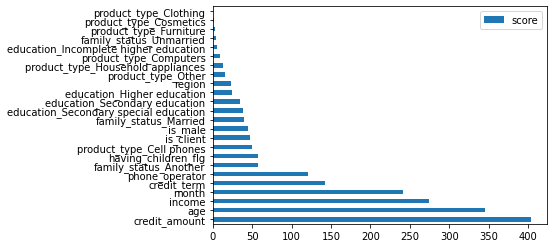

In [167]:
# 1. Select data with feature_importants
feature_important(xg_reg)

In [168]:
# 2. Select need features
threshold = 36

data = data.reset_index()
data = data[data.score>threshold]
columns = list(data['index'])


# 4. Select only interesting columns duruing training
x_train = x_train[columns]
x_test = x_test[x_train.columns]

#### 2.4 Train Naive model with prune data

In [169]:
%%time

# 0. set threshold 
threshold = 0.25

# 1. fitting 
xg_reg = xgb.XGBClassifier( n_jobs=5, random_state=777, objective='reg:logistic', use_label_encoder=False)
xg_reg.fit(x_train, y_train)


# 2. Prediction
prediction = xg_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
print('AUC: ', round(auc(fpr, tpr),2))


# 3. Prediction + threshold
prediction = np.where(prediction < threshold, 0, 1)

print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))

# 4. Save result
res_tab['auc'][1] = round(auc(fpr, tpr),2)
res_tab['recall'][1] = round(recall_score(y_pred = prediction, y_true = y_test),2)

AUC:  0.71
recall:  0.29
[[424  38]
 [ 39  16]]
Wall time: 87.8 ms


#### 2.5 Grid Search

In [120]:
# 1. Determine param for GS
learning_rate = [0.01,0.1,0.2,0.3] 
max_depth = [5,7,3] 
n_estimators = [100,200] 
subsample=  [1,0.75] 
colsample_bytree = [ 1]
gamma = [0.25, 0.1,0.2,0.3, 0]
i_index = [0]



# 2. Create GS table
GS_table(learning_rate, max_depth, n_estimators, subsample, colsample_bytree, gamma,i_index  )

(240, 11)


In [121]:
# 3. Data and folds fo GS
data = x_train.copy()
data['y'] = y_train 

# 3.1 Create folds
random.seed(777)
value = []
for i in range(0,len(data)):
    value.append(random.randint(1,3))
data['fold'] = value

In [122]:
# 4. GS process
for i in range(0,len(grid_tab)):
    for j in [1,2,3]:
        data_test = data[data.fold == j]
        data_train = data[data.fold != j]
    
    
    
        xg_reg = xgb.XGBClassifier(n_jobs=7, random_state=7,
                                 learning_rate = grid_tab.learning_rate[i],
                                 max_depth = grid_tab.max_depth[i],
                                 n_estimators = grid_tab.n_estimators[i],
                                 subsample = grid_tab.subsample[i],
                                 colsample_bytree = grid_tab.colsample_bytree[i],
                                 gamma = grid_tab.gamma[i],
                                objective='reg:logistic', use_label_encoder=False
                                 )
        xg_reg.fit(data_train.iloc[:,:(len(data_train.columns)-2)], data_train.y)

# Prediction
        prediction = xg_reg.predict_proba(data_test.iloc[:,:(len(data_train.columns)-2)])[:, 1]
        fpr, tpr, thresholds = roc_curve(data_test.y, prediction)
        metric = round(auc(fpr, tpr),2)
    
# Mae calculation for slices        
        if j == 1:
            grid_tab.auc1[i] = metric 
        elif j ==2:
            grid_tab.auc2[i] = metric 
        else:
            grid_tab.auc3[i] = metric    

                
# MAE avg
    grid_tab.auc_avg = (grid_tab.auc1 + grid_tab.auc2+ grid_tab.auc3)/3      
    print(i)  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


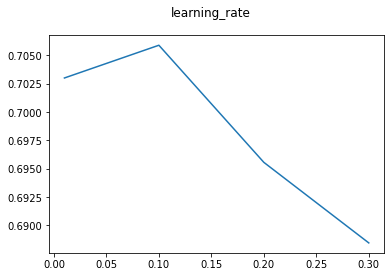

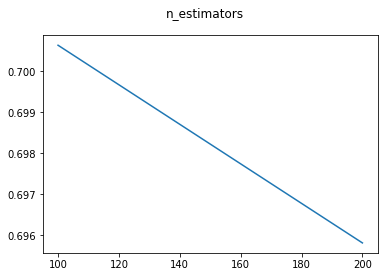

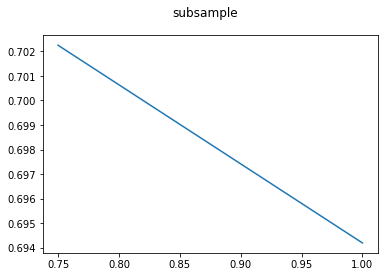

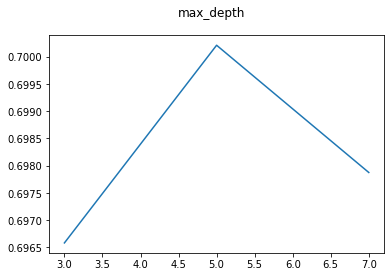

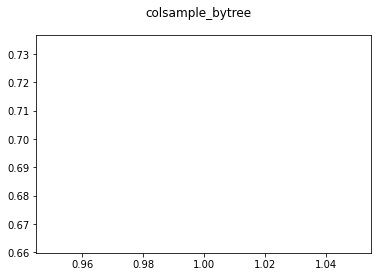

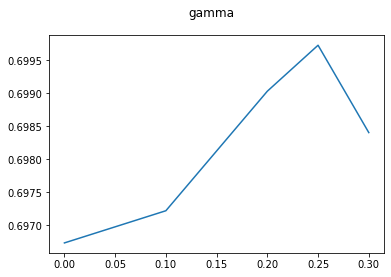

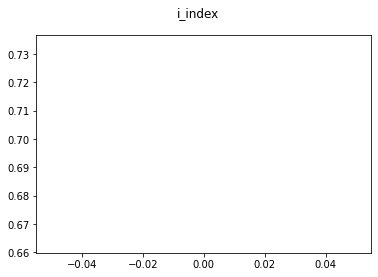

,learning_rate,n_estimators,subsample,max_depth,colsample_bytree,gamma,i_index,auc1,auc2,auc3,auc_avg
55,0.01,200,0.75,3,1,0.25,0,0.75,0.73,0.71,0.73
56,0.01,200,0.75,3,1,0.10,0,0.75,0.73,0.71,0.73
57,0.01,200,0.75,3,1,0.20,0,0.75,0.73,0.71,0.73
58,0.01,200,0.75,3,1,0.30,0,0.75,0.73,0.71,0.73
59,0.01,200,0.75,3,1,0.00,0,0.75,0.73,0.71,0.73


In [123]:
#### 5 Factor analysis

# 5.1 Look at data dynamic
# 5.2 Select need param
k =  ['learning_rate','n_estimators', 'subsample', 'max_depth','colsample_bytree','gamma','i_index']


# 5.3 Plot data
for X in k:
    t =grid_tab.groupby(X)[['auc_avg']].agg(np.mean)

    # Plot the data
    x = np.array(t.index)
    y  = np.array(t['auc_avg'])
    plt.plot(x, y)
    plt.suptitle(X)
    plt.show()
    
# 5.4 select the best param    
grid_tab[grid_tab.auc_avg == grid_tab.auc_avg.max()]    

#### 2.6 Advanced XGBoost model

In [170]:
%%time

# 0. set threshold 
threshold = 0.25

# 1. fitting 
xg_reg = xgb.XGBClassifier( n_jobs=7, random_state=777, objective='reg:logistic', use_label_encoder=False,
                         learning_rate = 0.01,
                          n_estimators = 200,
                          subsample = 0.75,
                          max_depth = 3,
                          colsample_bytree = 1,
                          gamma = 0.25
                          )
xg_reg.fit(x_train, y_train)


# 2. Prediction
pred = xg_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred)
print('AUC: ', round(auc(fpr, tpr),2))


# 3. Prediction + threshold
prediction = np.where(pred  < threshold, 0, 1)

print('recall: ', round(recall_score(y_pred = prediction, y_true = y_test),2))
print(confusion_matrix(y_test, prediction))

# 4. Save result
res_tab['auc'][2] = round(auc(fpr, tpr),2)
res_tab['recall'][2] = round(recall_score(y_pred = prediction, y_true = y_test),2)

AUC:  0.77
recall:  0.38
[[418  44]
 [ 34  21]]
Wall time: 176 ms


In [171]:
res_tab

,Method,auc,recall
0,naive,0.71,0.25
1,naive_plus_cleaning,0.71,0.29
2,advanced,0.77,0.38


#### 2.8 Dependdens recall on threshold 

In [172]:
# 1. table with recall / precision
rec_prec_threshold = pd.DataFrame({'threshold':np.arange(0.01, 0.5, 0.01),
             'Recall':np.nan,
              'Precision': np.nan} )

# 2. Main calculation
for i in range(len(rec_prec_threshold)):
    prediction = np.where(pred < rec_prec_threshold['threshold'][i], 0, 1)
    rec_prec_threshold['Recall'][i]  = round(recall_score(y_pred = prediction, y_true = y_test),2)
    rec_prec_threshold['Precision'][i]  = round(precision_score(y_pred = prediction, y_true = y_test),2)

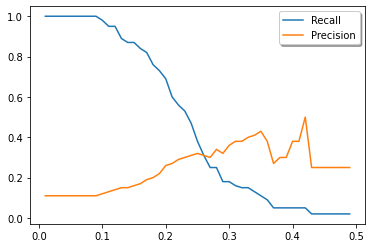

In [173]:
# 3. Plot it
x = rec_prec_threshold.threshold
y  = rec_prec_threshold.Recall
z = rec_prec_threshold.Precision
plt.plot(x, y);
plt.plot(x, z);
plt.legend(['Recall','Precision' ],shadow = True, loc = 1);    

#### Part 4. Conclusion

In [174]:
#  1. Result model 
model = xg_reg

# Model AUC
pred = model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred)


# В зависимости от цели задачи необходимо установить "порог" для определения плохих клиентов.
# Чем меньше порог, тем больше плохих клиентов получаеться отлавиливать, но возрастает ошибка первого рода.
# Рекомендую использовать график выше для определения оптимального порога, например,
# Если задача идентифицировать 50% плохих клиентов, то порог 0.23

# 3. Prediction + threshold
threshold = 0.23
prediction = np.where(pred  < threshold, 0, 1)


# 4. Итоговая confusion_matrix
print(confusion_matrix(y_test, prediction))

[[395  67]
 [ 26  29]]


In [129]:
# 5. Model evolution
res_tab

,Method,auc,recall
0,naive,0.71,0.25
1,naive_plus_cleaning,0.72,0.22
2,advanced,0.77,0.36


In [130]:
# 6. Параметры модели
columns

['credit_amount',
 'age',
 'income',
 'month',
 'credit_term',
 'phone_operator',
 'family_status_Another',
 'having_children_flg',
 'product_type_Cell phones',
 'is_client',
 'is_male',
 'family_status_Married',
 'education_Secondary special education',
 'education_Secondary education']

#### 7. Что можно еще сделать для улучшения качества модели? Зависит от поставновки задачи. Основные идеи:

1. Перебор других методов: Catboost, GBM, ADABoost, Random Forest
2. Удаление выбросов
3. Использование других метрик качетства: f-score
4. Преодолление проблемы неслансированности: Oversampling, undersampling, weighted methods - Эти методы помогают редко.
5. Feature engenirng    